# Debugowanie i profilowanie kodu

Jeśli jest jedna cecha, którą każdy utożsamia z Pythonem, to jest nią z pewnością łatwość zrozumienia kodu i relatywna łatwość pisania kodu w tym języku. Przyczyniło się to do niesamowitej popularności tego języka, jednak wszystkie takie cechy mają swój koszt. Czysty Python jest zazwyczaj 2 rzędy wielkości wolniejszy niż kod w językach kompilowanych - w przypadku mnożenia macierzy (będącego co warto zauważyć podstawą AI, gdzie Python zdobył szczególną popularność) BLAS zaimplementowany w C jest 60000x szybszy niż czysty Python.
Drugi istotny koszt to pamięć: przykładowo jeden znak w C to 1 bajt (chyba, że używamy unicode), w Pythonie to aż 28 bajtów! Struktury danych w Pythonie zwierają wiele metadanych - choćby liczniki odwołań, a odśmiecanie w niektórych przypadkach odbywa się z opóźnieniem.
Jak na popularny język przystało, istnieje wiele narzędzi, które pomagają profilować kod i wskazywać na fragmenty wymagające optymalizacji. Bogaty ekosystem narzędzi umożliwia też poprawienie doświadczenia programisty w zakresie debugowania i diagnozowania problemów - w poniższym module przybliżę kilka z takich narzędzi.

## Wbudowane narzędzia - `cProfile`, `tracemalloc` i `PDB` oraz ich ograniczenia
Gdy zainstalujemy standardową implementację Pythona (cPython), mamy do dyspozycji wbudowane narzędzia do profilowania (cProfile) i debugowania kodu (PDB). 

### PDB
Aby uruchomić wbudowany debugger wystarczy, że dodamy w naszym kodzie linijkę:

In [1]:
breakpoint()

lub w starszych Pythonach:

In [ ]:
import pdb
pdb.set_trace()

Czasami możemy chcieć zdebugować miejsce w kodzie, które rzuca wyjątkiem. Wówczas - jeśli jesteśmy w stanie wywołać błędną sytuację - możemy uruchomić debugowanie w trybie post mortem tak:

In [ ]:
import pdb
import crashing_module

crashing_module.crash()
pdb.pm()

Wówczas `pdb` skorzysta z informacji o tracebacku zapisanej w `sys.last_traceback` i otworzy sesję debugowania w stanie i miejscu po wystąpieniu wyjątku.

### Przydatne komendy w trybie debugowania:
- **b [miejsce]** - ustawia breakpoint w danym miejscu
- **c** - kontynuuje wykonanie aż do kolejnego breakpointu lub do końca programu
- **s** - wykonuje krok - albo wykonuje wywołanie funkcji wewnątrz której natychmiast staje albo przechodzi do kolejnej linii
- **n** - przechodzi do nowej linii w danej ramce
- **ll** - wypisuje aktualną linijkę kodu i jej otoczenie wewnątrz aktualnej ramki
- **u** - ramka w górę
- **d** - ramka w dół
- **w** - gdzie aktualnie znajduje się wykonanie
- **p [wyrażenie]** - wypisuje wartość wyrażenia
...
Wszystkie można znaleźć [tu](https://docs.python.org/3/library/pdb.html)

Czy istnieją wygodniejsze narzędzia? Tak, chociażby interfejsy debuggerów oferowane przez większość IDE (VS Code, PyCharm). Dużym plusem PDB jest jednak jego powszechność - praktycznie każda instalacja Pythona posiada wbudowane PDB, które można uruchomić ad hoc w dowolnym miejscu bez dostępu do internetu czy wcześniejszeej konfiguracji- nawet debugując poboczny projekt na Raspberry PI ;)

### cProfile
Analogicznie w świecie profilerów istnieja dużo lepsze narzędzia od cProfile - np. yappi, py-spy, scalene czy memray. Każde z nich jednak wymaga doinstalowania - a nie rzadko również konfiguracji, co nie w każdej sytuacji jest możliwe. Dodatkowo, zwykle mija trochę czasu zanim narzędzia zaimplementują pełne wsparcie dla nowej wersji Pythona. Wówczas możemy skorzystać z cProfile - profilera, który powinien być dostepny zaraz po zainstalowaniu Pythona i który z pewnością wspiera najnowszą wydaną wersję języka. cProfile umożliwia:
- mierzenie czasu wykonania kodu
- mierzenie czasu wykonania kodu z rozbiciem na kroki
- sprawdzenie ile razy wykonały się poszczególne funkcje
- zrzucenie tych danych w formacie prostym do wizualizacji (np.: modułem `snakeviz`)
Aby go użyć wystarczy:

In [ ]:
import cProfile

code1 = """
lst = []
for i in range(10000):
    lst.append(i)
"""

code2 = """
lst = [i for i in range(10000)]
"""
cProfile.run(code1)
cProfile.run(code2)

Czasami chcemy mieć większą swobodę pracy z danymi zebranymi przez `cProfile` - wówczas możemy skorzystać z modułu `pstats`. Przykładowo, chcemy znaleźć 2 funkcje, które są wykonywane najwięcej razy. Robimy to tak:

In [1]:
def dodaj(l, el):
    l.append(el)

def sortuj(l):
    res = []
    for el in sorted(l):
        res.append(el)
    return res
    
def main():
    lst = [1,2,3]
    for i in range(1000):
        dodaj(lst, 2 * i)
    lst = sortuj(lst)

if __name__ == '__main__':
    import cProfile, pstats
    profiler = cProfile.Profile()
    profiler.enable()
    main()
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats('ncalls')
    stats.print_stats(2)

         3007 function calls in 0.001 seconds

   Ordered by: call count
   List reduced from 6 to 2 due to restriction <2>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     2003    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
     1000    0.000    0.000    0.001    0.000 /var/folders/10/9_0llp4x10g06bf6mknlsx0c0000gn/T/ipykernel_34839/2789977897.py:1(dodaj)




Znaczenie kolumn jest następujące:
- **ncalls**: Ile razy dana funkcja była zawołana 
- **tottime**: Łączny czas w funkcji, bez uwzględnienia czasu w funkcjach z niej wołanych
- **percall**: Średni czas w funkcji na jedno wywołanie, tak naprawdę tottime / ncalls.
- **cumtime**: Łączny czas spędzony w funkcji i funkcjach z niej wołanych
- **percall**: Średni czas spędzony w funkcji i funkcjach z niej wołanych na wywołanie, tak naprawdę cumtime / ncalls.
filename:lineno(function): Nazwa pliku, linia i nazwa funkcji

### Wizualizacja danych z cProfile
Aby zwizualizować dane zebrane przez cProfile wystarczy, że zainstalujemy bibliotekę `snakeviz`:
```
pip install snakeviz
```

Następnie jeśli chcemy jej użyć w Jupyterze musimy załadować rozszerzenie:
```
%load_ext snakeviz
```

i wywołać:
```
%snakeviz nazwa_funkcji()
```

In [2]:
import random

def print_msg():
    for i in range(12):
        print("cześć!")


def generate_random_data():
    data = [random.randint(0, 99) for p in range(0, 1000)]
    return data

# Function to search 
def search_function(data):
    for i in data:
        if i in [111, 222, 333, 444, 555, 666]:
            print("znaleziono: ", i)

def main():
    data=generate_random_data()
    search_function(data)
    print_msg()

# !pip install snakeviz
%reload_ext snakeviz
%snakeviz main()

cześć!
cześć!
cześć!
cześć!
cześć!
cześć!
cześć!
cześć!
cześć!
cześć!
cześć!
cześć!
 
*** Profile stats marshalled to file '/var/folders/10/9_0llp4x10g06bf6mknlsx0c0000gn/T/tmpiz0h0irk'.
Embedding SnakeViz in this document...
<function display at 0x105b21940>


## Tracemalloc
Tracemalloc to moduł do profilowania zużycia pamięci, który podobnie jak cProfile dostępny jest w bibliotece standardowej. Podmienia on po prostu allocator pamięci wykorzystywany przez interpreter Pythona na taki, który zostawia ślad każdej alokacji i umożliwia w ten sposób identyfikację fragmentów kodu, które alokują dużo pamięci, oraz analizę wycieków pamięci.

### Użycie


In [4]:
import tracemalloc

def allocate_memory():
    a = [i for i in range(1000000)]
    return a

tracemalloc.start()

# Uruchom funkcję, której używanie pamięci chcesz zbadać
allocate_memory()

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

print("[ Top 10 ]")
for stat in top_stats[:10]:
    print(stat)

[ Top 10 ]
/Users/kkwisniewski/Repos/bottega/oop_concurrency_profiling/env/lib/python3.11/site-packages/IPython/core/compilerop.py:86: size=10.8 KiB, count=105, average=105 B
/Users/kkwisniewski/.pyenv/versions/3.11.4/lib/python3.11/json/decoder.py:353: size=2364 B, count=25, average=95 B
/Users/kkwisniewski/.pyenv/versions/3.11.4/lib/python3.11/codeop.py:118: size=1880 B, count=24, average=78 B
/Users/kkwisniewski/Repos/bottega/oop_concurrency_profiling/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:1536: size=1520 B, count=1, average=1520 B
/Users/kkwisniewski/Repos/bottega/oop_concurrency_profiling/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3329: size=1492 B, count=2, average=746 B
/Users/kkwisniewski/Repos/bottega/oop_concurrency_profiling/env/lib/python3.11/site-packages/IPython/core/compilerop.py:174: size=1193 B, count=13, average=92 B
/Users/kkwisniewski/Repos/bottega/oop_concurrency_profiling/env/lib/python3.11/site-packages/zmq/sugar/

### Ograniczenia
- **Wygoda użycia**: Chociaż tracemalloc jest narzędziem wbudowanym, wymaga dodatkowego kodu do zbierania i analizy danych. Niektóre zewnętrzne narzędzia mogą oferować bardziej zaawansowane i przyjazne dla użytkownika interfejsy.
- **Wydajność**: tracemalloc wprowadza pewien narzut wydajnościowy, co może być problemem, gdy analizujemy kod, który jest krytyczny pod względem wydajności.
- **Ograniczone informacje**: tracemalloc skupia się na śledzeniu alokacji pamięci i nie dostarcza tak dogłębnych informacji o używanej pamięci jak niektóre zewnętrzne narzędzia.
- **Brak wsparcia dla rozszerzeń w C**: tracemalloc nie śledzi alokacji pamięci dokonywanych przez wewnętrzne funkcje CPythona czy biblioteki zewnętrzne napisane w C.

## Wybór profilera
Ekosystem Pythona oferuje wiele różnych rozwiązań umożliwiających profilowanie kodu. Jak wybrać najbardziej odpowiedni? Powinniśmy precyzyjnie określić swoje oczekiwania:
- czy jesteśmy zainteresowani profilowaniem latencji ogonowej czy przypadku średniego?
- czy potrzebujemy informacji o wydajności na poziomie funkcji czy pojedynczych linii kodu?
- czy jesteśmy w stanie zaakceptować spadek wydajności aplikacji i jeśli tak to jak duży?
- czy kod, który profilujemy jest kodem współbieżnym?
- czy fragmenty profilowanego programu zaimplementowane są w C lub używają bibliotek, które są?
- czy kod wykonuje się na CPU czy GPU?
- wreszcie: czy zależy nam na profilowaniu użycia procesora/karty graficznej czy pamięci?

### Profilery śledzące vs profilery statystyczne
Ze wzgledu na narzut wydajnościowy i rozmiar dokładnych trace'ów zdecydowana większość profilerów to profilery statystyczne - z określoną częstotliwością, zazwyczaj w okolicy 1kHz. Tą częstotliwość można oczywiście regulować, jednak zbyt duża doprowadzi do spadku wydajnośći i wygenerowania ogromych ilości danych w krótkim czasie. W między kolejnymi próbkami jednak może zajść wiele zdarzeń, które mają przeważający wpływ na opóźnienia - takie podejście nie sprawdza się więc gdy jesteśmy zadowoleni ze średniego przypadku, a debugujemy pojedyncze dłuższe opóźnienia w ogonie rozkładu - wtedy pozostaje nam podejście oparte o tracing. W tym przypadku należy dobrze określić konkretny typ zdarzeń, które są dla nas interesujące, ponieważ ich ilość może szybko przekroczyć nasze możliwości ich przechowywania i przetwarzania. W Linuksie standardem obecnie jest `perf`, czyli kombajn mogący śledzić prawie wszystkie zdarzenia systemowe. Jest on jednak dość trudny w użyciu (wymaga np. specjalnie skonfigurowanego kernela) i ze względu na swoją ogólność nie jest przedmiotem tego szkolenia. Inne profilery śledzące to np `pprofile` w trybie deterministycznym, jednak nie wspierają one zazwyczaj wielu przypadków użyciu - choćby profilowania kodu na GPU czy wieloprocesowego. Dodatkowo profilery trace'ujące zazwyczaj wymagają jakiejś formy instrumentacji kodu przez jego modyfikację, co dodatkowo utrudnia ich użycie. W przeciwieństwie do nich, profilery statystyczne często umożliwiają nawet działanie programu w sposób ciągły w warunkach produkcyjnych bez znaczącego spadku wydajności.

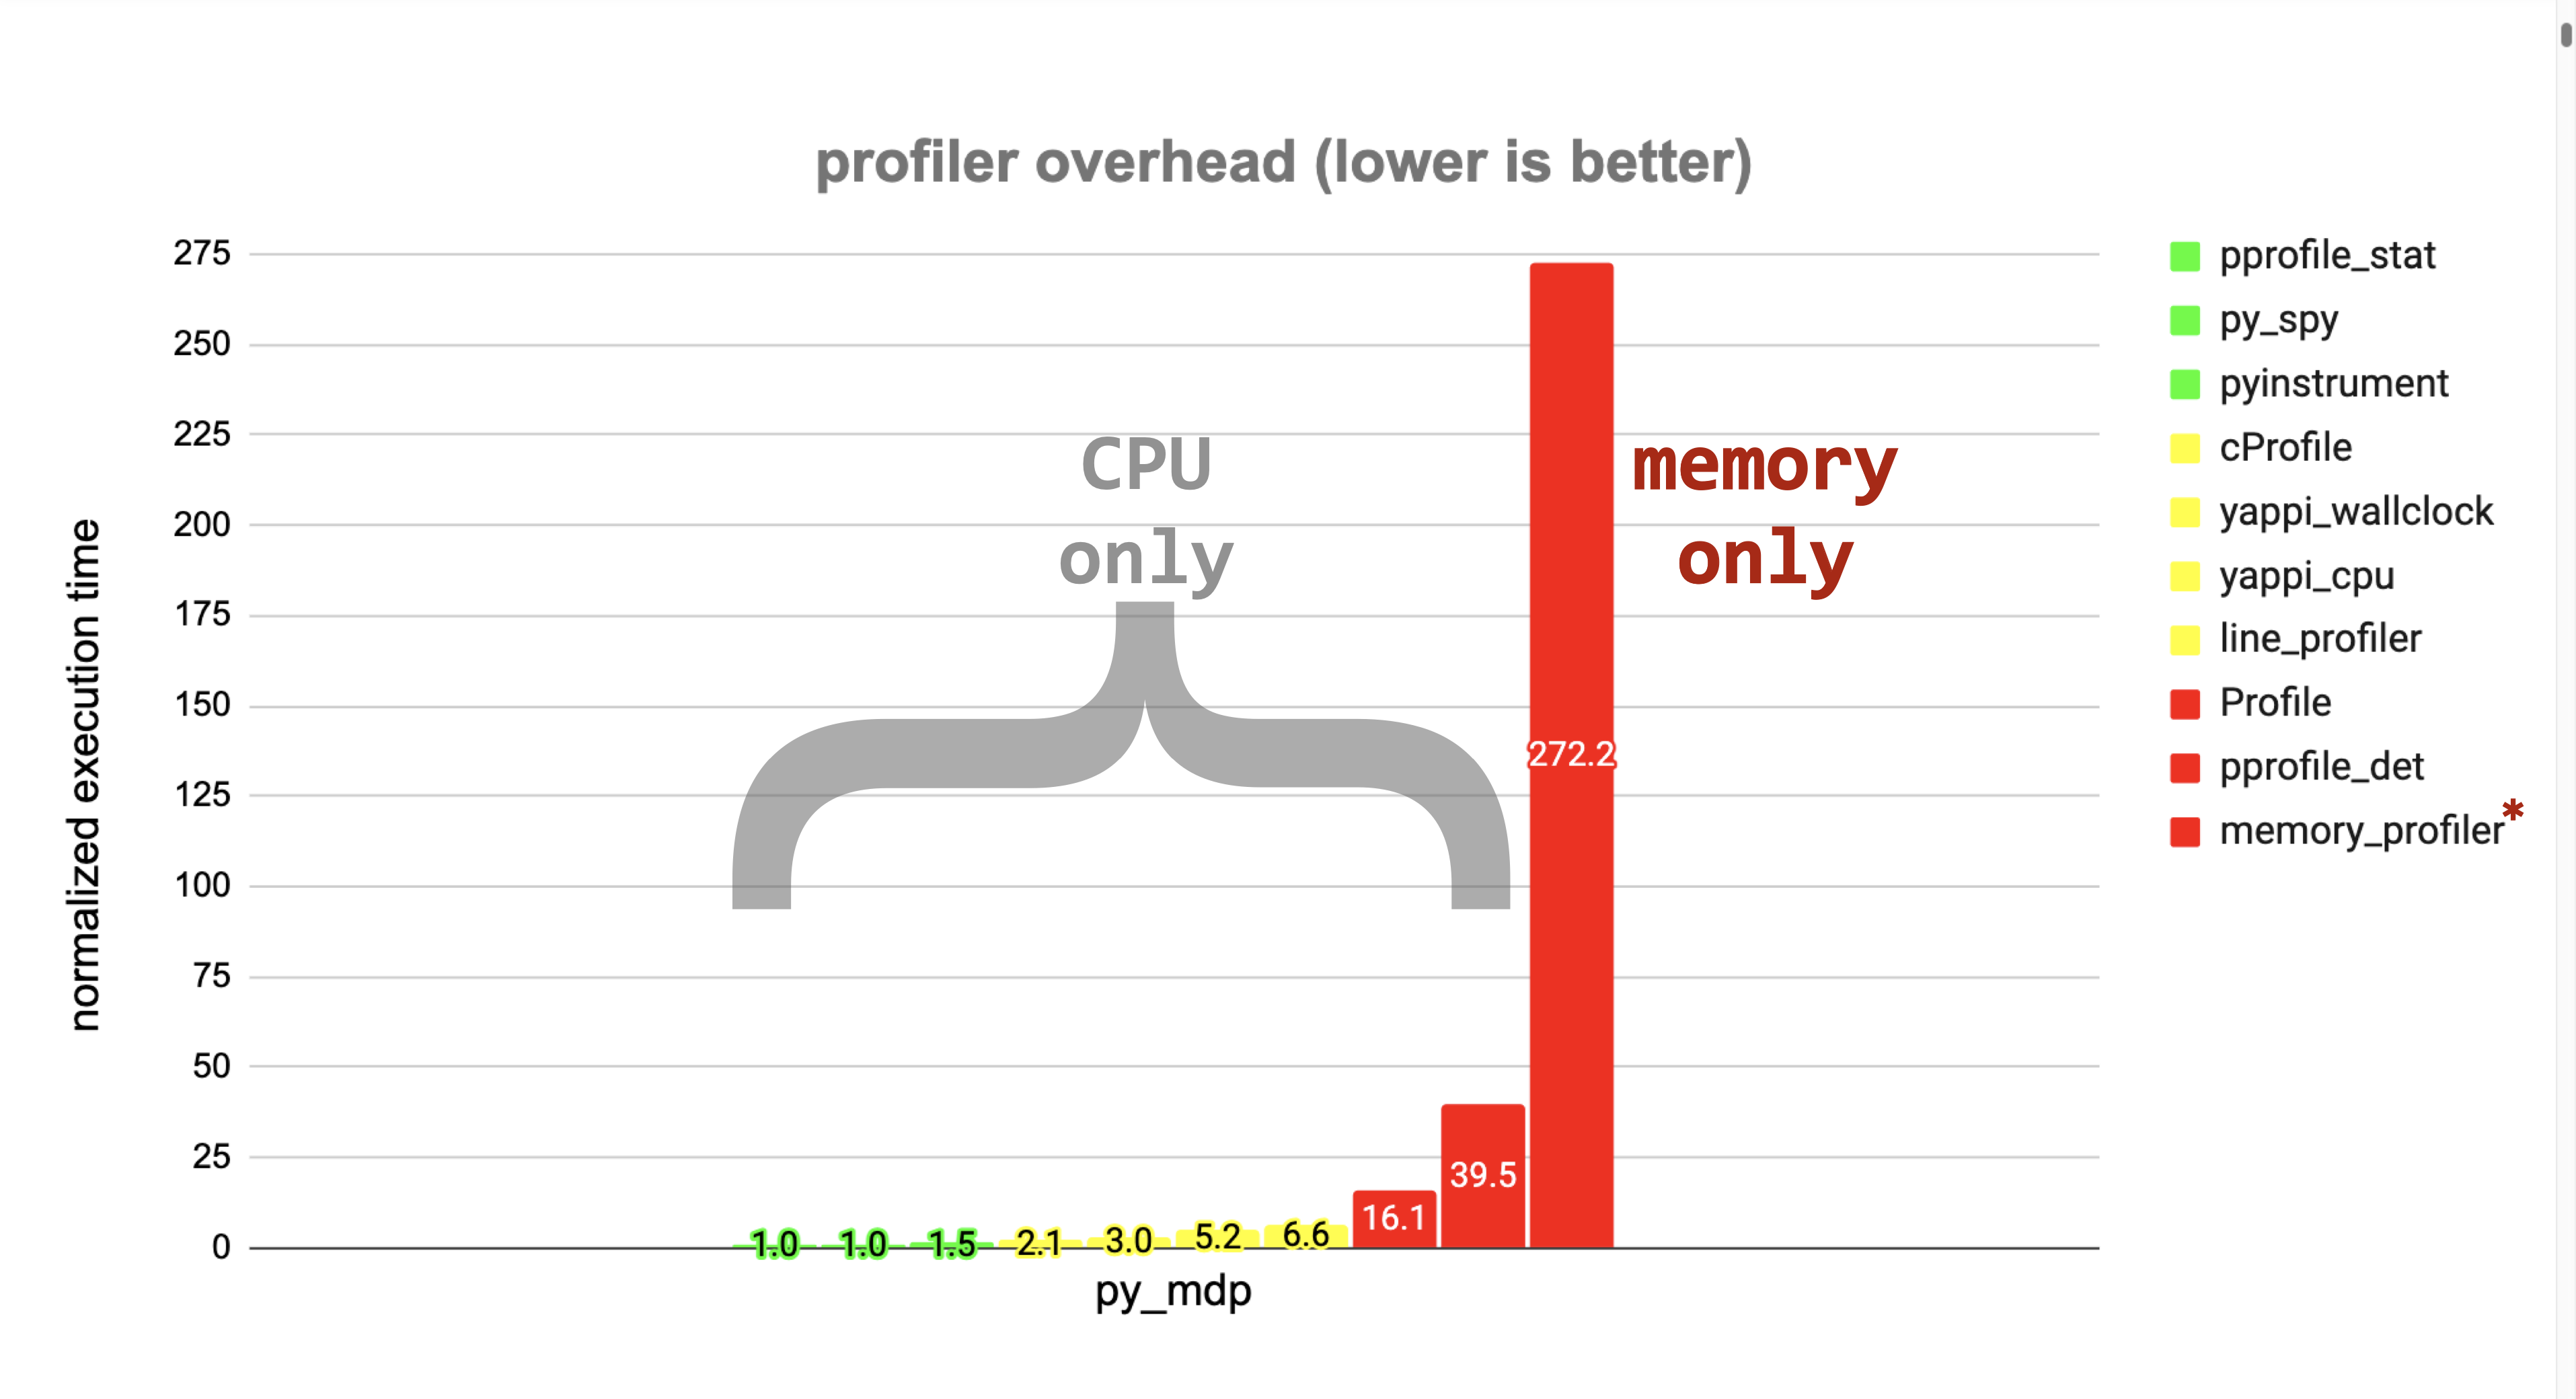
*źródło: https://www.youtube.com/watch?v=nrQPqy3YY5A*

Jak widać różnice w narzucie wydajnościowym powodowanym przez profiler są znaczące. Niektóre profilery kompletnie nie nadają sie do zastosowania w środowiskach produkcyjnych - w szczególności profiler pamięci `memory_profiler` powoduje aż 272x spowolnienie! Inne wymienione powyżej wymagania również mogą znacząco zawęzić nasz wybór. Tabela poniżej pokazuje porównanie różnych profilerów z wyszczegolnieniem ich cech:
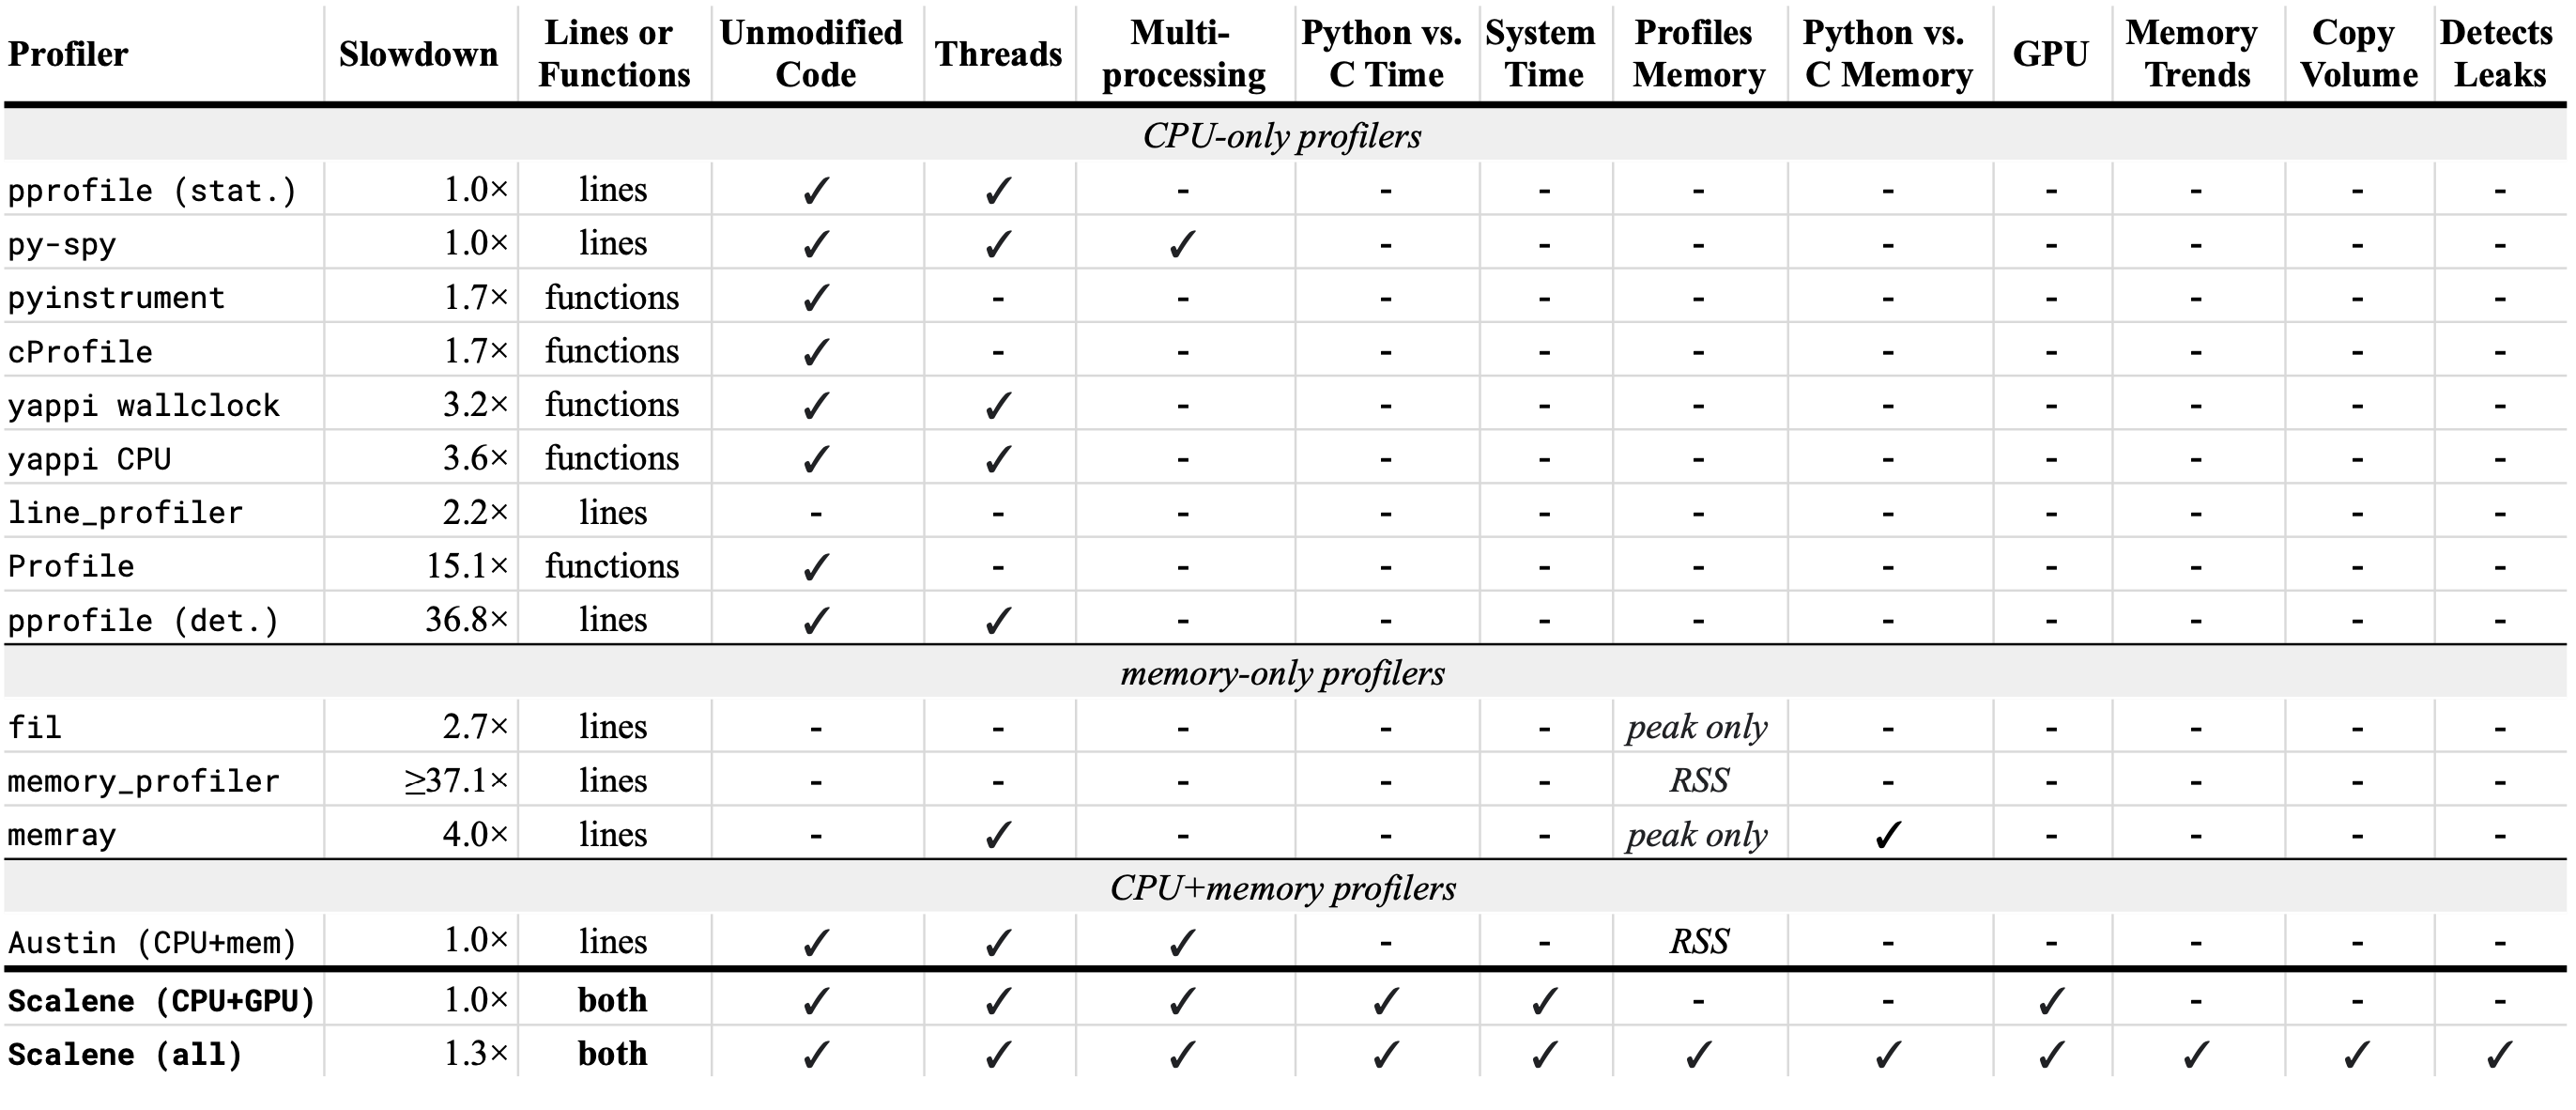
*źródło: https://arxiv.org/pdf/2212.07597.pdf*

Na samym końcu tabeli widzimy Scalene - obecnie prawdopodobnie najbardziej uniwersalny profiler w świecie Pythona - zarówno jeśli chodzi o profilowanie pamięci, jak i zużycia procesora oraz GPU! Do tego wspiera profilowanie kodu współbieżnego a nawer kodu wykonującego się na GPU! To dość unikalne połączenie cech, które powoduje, że szczególnie dobrze nadaje się do profilowania kodu korzystającego z bibliotek numerycznych. W świecie Pythona normą jest, że intensywne obliczeniowo fragmenty kodu implementuje się z użyciem bibliotek, które są zaimplentowane w C lub CUDA. Dla większości profilerów Pythona te fragmenty kodu są jednak nieosiągalne, podobnie jak kod wykonujący się na specjalizowanych koprocesorach takich jak GPU. Uważni uczestnicy mogą zadawać sobie pytanie o koszt wydajnościowy takiego rozbudowanego profilera. Na szczęście, narzut jest stosunkowo mały, nawet gdy profilujemy pamięć:
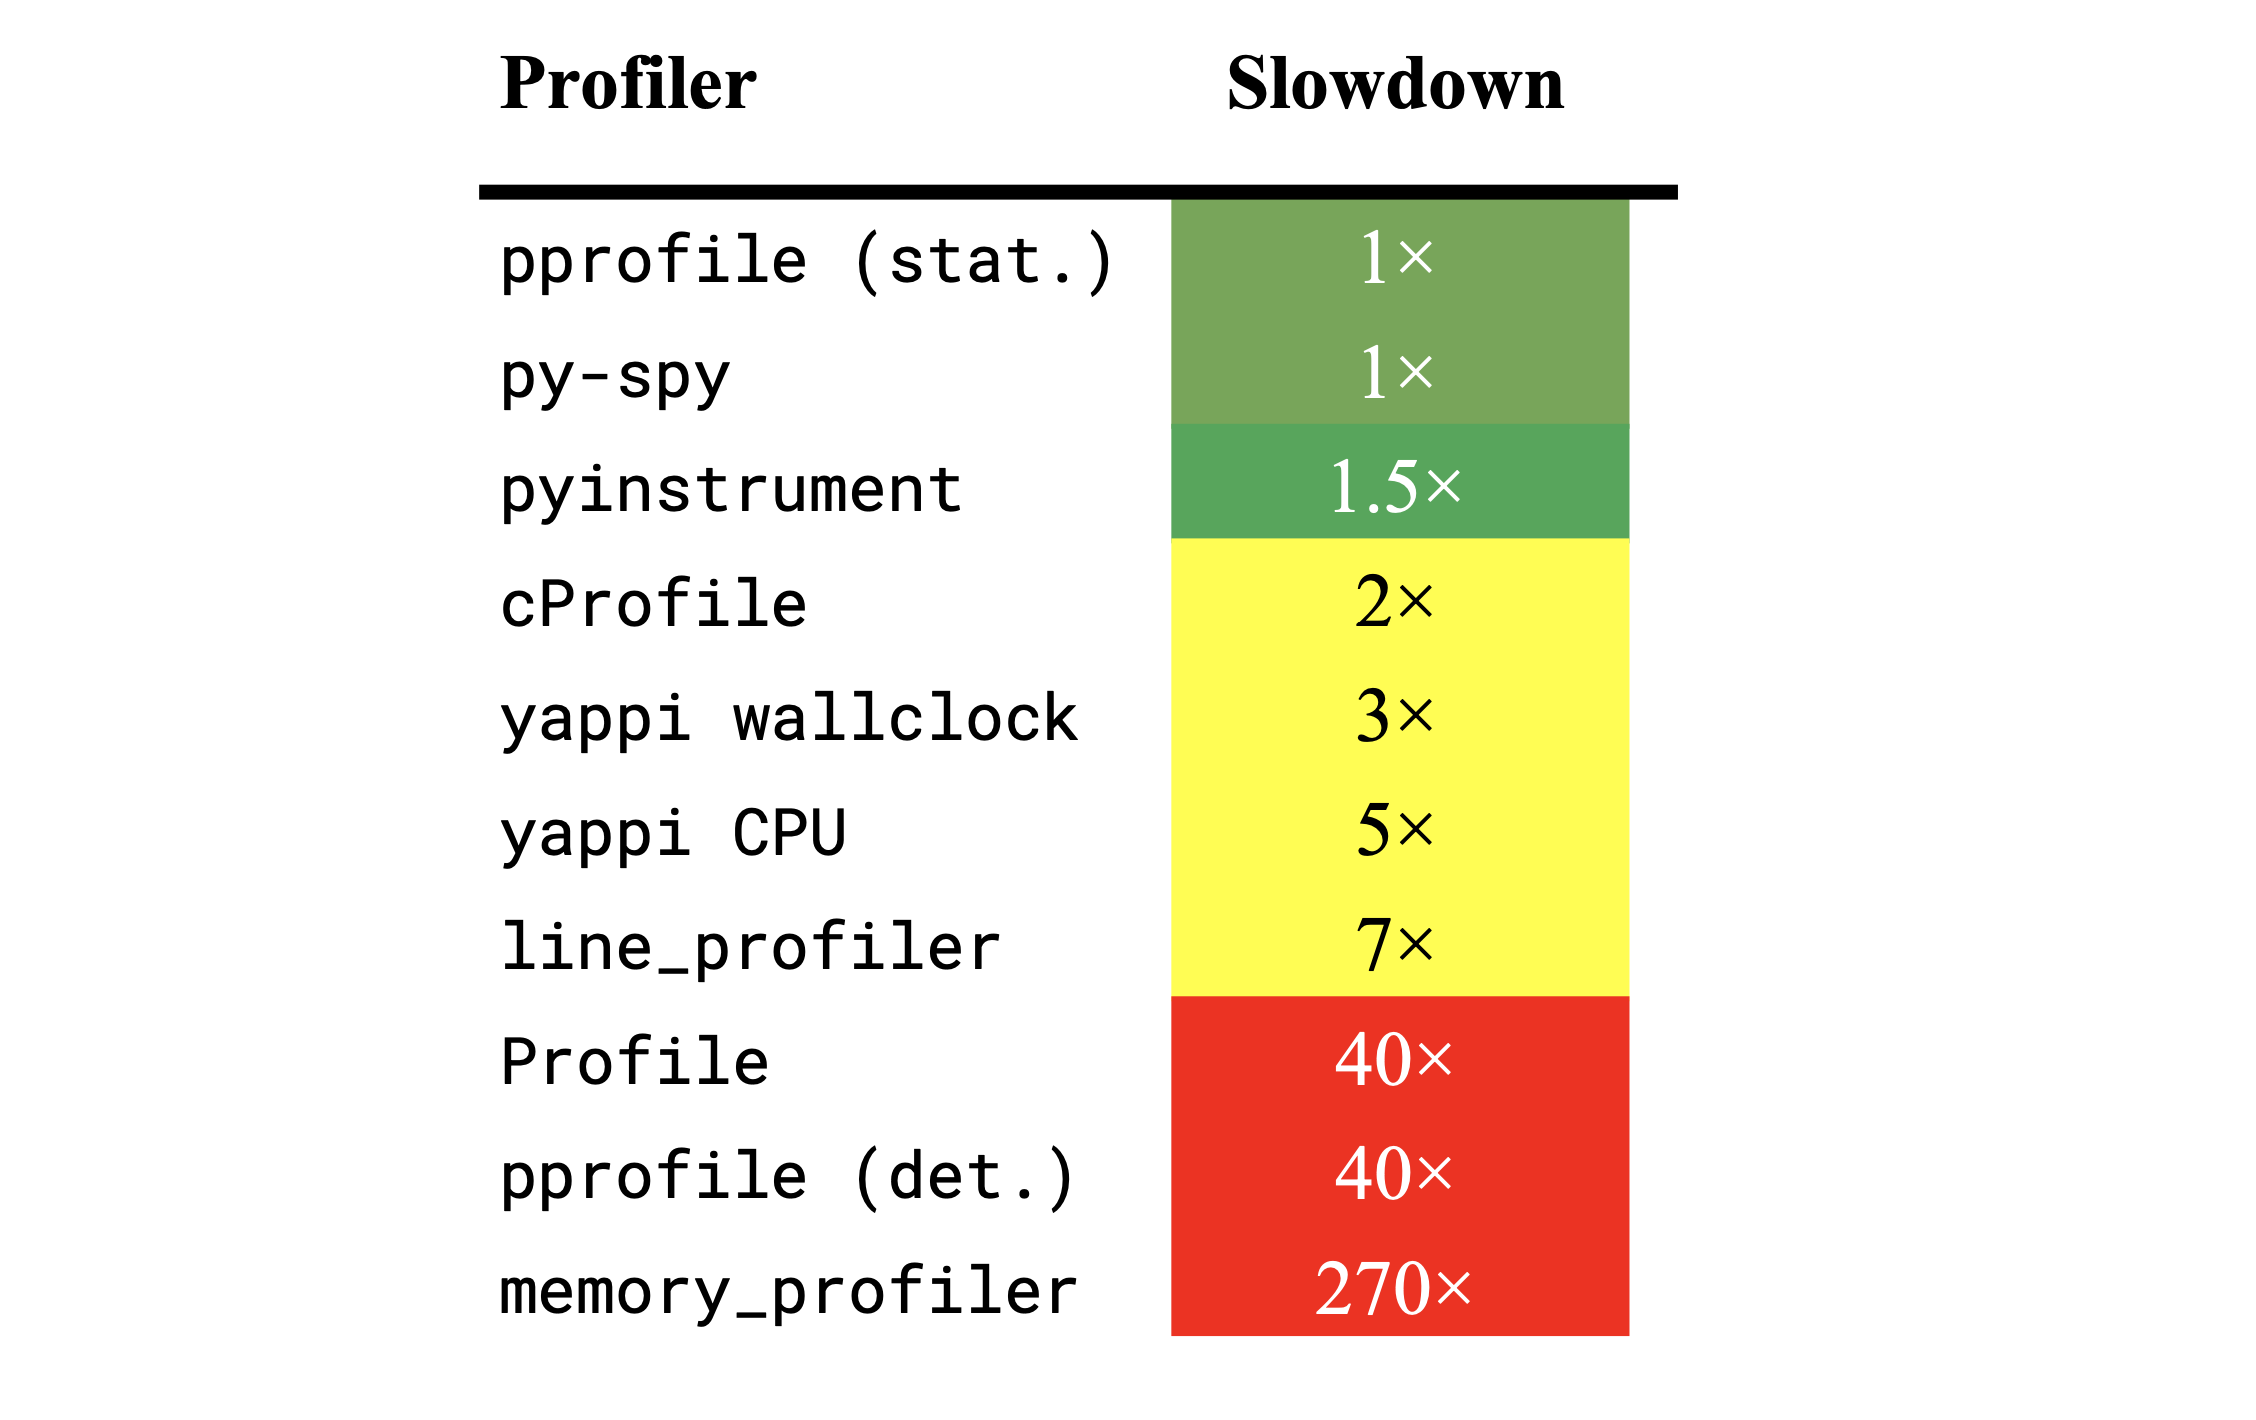
*źródło: https://www.youtube.com/watch?v=nrQPqy3YY5A*

## Profilowanie wykorzystania CPU i pamięci z użyciem `scalene`
[Strona scalene na Github](https://github.com/plasma-umass/scalene)
Aby użyć `Scalene` wystarczy go zainstalować:
```
pip install scalene
```
a następnie uruchomić nasz program zamieniając `python` na `scalene` w wierszy polecenia:
```
scalene --html program.py
```
Warto dodać opcje `--html`, aby uzyskać łatwiejszy do czytania output w postaci strony HTML, którą można otworzyć w przeglądarce. Duże programy zyskają zazwyczaj korzystają na dodaniu opcji `--reduced-profile` pomijającej nieistotne linie kodu (tj. takie, które nie powodują znaczącego narzutu) lub `--profile-only`, która sprofiluje tylko wybrane pliki. Czasami mamy już też podejrzenie co do tego, który kawałek kodu jest problematyczny - możemy wtedy dekorować wybrane funkcje dekoratorem `@profile`, by dostać tylko output dotyczący tych funkcji. Jeśli chcemy profilować również biblioteki załączane przez nasz program, przydaje się opcja `--profile-all` jednak jej output potrafi "przyćmić" miejsca w naszym kodzie, które wymagają przeróbki.

#### Demo
[Demo Scalene](http://plasma-umass.org/scalene-gui/)


#### Użycie w kodzie

In [ ]:
from scalene import scalene_profiler

# Turn profiling on
scalene_profiler.start()

# Turn profiling off
scalene_profiler.stop()